# OneHot + ProtVec BRNN

In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet('Metal_all_20180116.snappy.parquet')
# print ('***** Data Types *****' + '\n' + str(df.dtypes) + '\n\n' + 
#        '***** Unique Ligands *****' + '\n' + str(df.ligandId.unique()))

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)

del df,df_zn,df_zn_single

In [2]:
# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i]:
#         print('Removing...' + str(i))
        rows_to_delete.append(i)        
        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
print ("Sequence length is " + str(seqs.shape[0]))

Sequence length is 22784


In [36]:
symbol_counts = {}
for i in range(seqs.shape[0]):
    for j in range(target[i].shape[0]):
        if seqs[i][target[i][j]] not in symbol_counts.keys():
            symbol_counts[seqs[i][target[i][j]]] = 1
        else:
            symbol_counts[seqs[i][target[i][j]]] += 1

print ('Symbol Dict: ', symbol_counts)
print ('Total: ', sum(symbol_counts.values()))
print ('[C,H / Total]: ', (symbol_counts['C'] + symbol_counts['H']) / sum(symbol_counts.values()))

Symbol Dict:  {'D': 9266, 'S': 185, 'H': 29210, 'C': 37542, 'E': 4625, 'K': 831, 'G': 47, 'Y': 75, 'N': 217, 'Q': 48, 'A': 31, 'W': 44, 'T': 147, 'R': 32, 'M': 21, 'F': 14, 'I': 18, 'V': 11, 'L': 24, 'P': 2}
Total:  82390
[C,H / Total]:  0.8101954120645709


#### Proportion of C,H binding sites 

All seqs: 0.37

Zn-binded, single-chain: 0.81

In [3]:
# Filepaths
dict_path = "./dictionaries/"
model_path = "./models/"
hist_path = "./histories/"
fig_path = "./figs/"

# ProtVec
n_gram_size = 3
dimension = 100

# Onehot


# Whether to use simple onehot encoding for inputs
UseOnehot = True
UseReplicate = False

### Input - ProtVec Embedding

In [4]:
# Load
seqs_dict = {}
with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
        seqs_dict = json.load(fp)

### Input - Onehot Encoding

In [5]:
onehot_keys = []
for i in range(seqs.shape[0]):
    for j in range(len(seqs[i])):
        if seqs[i][j] not in onehot_keys:
            onehot_keys.append(seqs[i][j])
# import operator
# print (sorted(seqs_dict_onehot.items(), key=operator.itemgetter(1)))
onehot_keys = np.array(onehot_keys).reshape(-1)
np.random.shuffle(onehot_keys)

seqs_dict_onehot = {}
onehot_matrix = np.eye(onehot_keys.shape[0])
for i in range(onehot_keys.shape[0]):
    seqs_dict_onehot[onehot_keys[i]] = onehot_matrix[i].tolist()

In [6]:
seqs_dict_onehot = {}
with open(dict_path + "seqs_dict_onehot", 'r') as fp:
        seqs_dict_onehot = json.load(fp)

In [7]:
seqs_dicts = [seqs_dict_onehot, seqs_dict]

In [ ]:
if UseOnehot:
    n_gram_size = 1
    dimension = onehot_keys.shape[0]
    seqs_dict = seqs_dict_onehot

### Construct feature vector
<img src="./figs/length_dist.png">

In [8]:
# Onehot encoding given a cutoff (Padded with 0s / Replicate partial sequence at the end)
def to_onehot(target_single, cutoff, seq_size, replicate=False):
    t = [0] * cutoff
    offset = cutoff - seq_size
    for i in target_single:
        t[i] = 1 
        if replicate and (i >= seq_size-offset) and (i < seq_size):
            t[offset+i] = 1
    return t

# Convert n-gram to vector given a dictionary
def to_vector(seqs_dict, seq, index, n_gram_size, dimension):
    if (index+n_gram_size) < len(seq):
        word = seq[index: index+n_gram_size]
        if '0' not in word:
            if word in seqs_dict.keys():
                return seqs_dict[word]
    return [0] * dimension

# Discard sequences longer than the cutoff and reconstruct datasets
def optimal_cutoff(seqs, target, cutoff, replicate=False):
    new_seqs = []
    new_target = []
    new_lengths = []
    for i, s, t in zip(range(seqs.shape[0]), seqs, target):
        if len(s) <= cutoff:
            if replicate:
                offset = cutoff-len(s)
                s = s + s[len(s)-offset : len(s)]
                new_seqs.append(s)
            else:
                new_seqs.append(s + (cutoff-len(s)) * '0')
            new_target.append(to_onehot(t,cutoff,len(s), replicate))
            new_lengths.append(len(s))
    return new_seqs, new_target, new_lengths

# Construct input tensor (Num_Samples x Cutoff X Dimension)
def construct_X(seqs_dict, seqs, cutoff, n_gram_size, dimension, sample_size, start_index):
    X = np.zeros((sample_size, cutoff, dimension))
    for i in range(sample_size):
        for j in range(cutoff):
            X[i][j] = np.array(to_vector(seqs_dict, seqs[start_index + i], j, n_gram_size, dimension))
    return X

# Get a pair of inputs for testing
def randomSample(X, Y):
    size = X.shape[0]
#     print (X.shape)
#     print (Y.shape)
    r = np.random.randint(size)
    retX = X[r].reshape((1, X.shape[1], X.shape[2]))
    retY = Y[r].reshape((1, Y.shape[1]))
    return (retX, retY)

# Paired randomization 
def shuffleXY(X, Y):
    C = list(zip(X, Y))
    random.shuffle(C)
    X_ret, Y_ret = zip(*C)
    return X_ret, Y_ret

In [9]:
lengths = np.zeros(len(seqs))
for i in range(len(seqs)):
    lengths[i] = len(seqs[i])

cutoff = int(np.mean(lengths) + 2 * np.std(lengths))
print ('Cutoff is ' + str(cutoff))
cv_ratio = 0.9

X, T, L = optimal_cutoff(seqs, target, cutoff, UseReplicate)
X_train, X_val = X[:(int)(len(X) * cv_ratio)], X[(int)(len(X) * cv_ratio):]
T_train, T_val = T[:(int)(len(T) * cv_ratio)], T[(int)(len(T) * cv_ratio):]
print ('Training set size is ' + str(len(X_train)))
print ('Test set size is ' + str(len(X_val)))

Cutoff is 706
Training set size is 19577
Test set size is 2176


In [10]:
from keras.layers import LSTM, Dense,Dropout, TimeDistributed, Bidirectional, Input, Concatenate, Flatten
from keras.callbacks import Callback
from keras.models import Model, load_model
# Visualization
from keras.utils import plot_model
# Custom layer
from keras import backend as K
from keras.engine.topology import Layer


import random

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


In [11]:
def random_sample_n_times(X, Y, size):
    X1, X2 = X
    n = X1.shape[0]
    _X1, _X2, _Y = [], [], []
    for i in range(size):
        r = np.random.randint(n)
        _X1.append(X1[r].tolist())
        _X2.append(X2[r].tolist())
        _Y.append(Y[r].tolist())
        
    _X = [np.asarray(_X1), np.asarray(_X2)]
    _Y = np.asarray(_Y)
    
    return _X, _Y
    
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

class roc_callback(Callback):
    def __init__(self,training_data,validation_data, sample_size):
        self.sample_size = sample_size
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        return
    
    def on_epoch_end(self, epoch, logs={}):
        x, y = random_sample_n_times(self.x, self.y, self.sample_size)
        x_val, y_val = random_sample_n_times(self.x_val, self.y_val, self.sample_size)

        y_pred = self.model.predict(x)
        y_pred_val = self.model.predict(x_val)

        roc = roc_auc_score(y.ravel(), y_pred.ravel())
        roc_val = roc_auc_score(y_val.ravel(), y_pred_val.ravel())

        
        y_pred = (y_pred > 0).astype(int)
        y_pred_val = (y_pred_val > 0).astype(int)
        
        f1 = f1_score(y.ravel(), y_pred.ravel())
        precision = precision_score(y.ravel(), y_pred.ravel())
        recall = recall_score(y.ravel(), y_pred.ravel())
        
        f1_val = f1_score(y_val.ravel(), y_pred_val.ravel())
        precision_val = precision_score(y_val.ravel(), y_pred_val.ravel())
        recall_val = recall_score(y_val.ravel(), y_pred_val.ravel())
        
#         print (roc_val, f1_val, precision_val, recall_val)
        self.roc_scores.append((round(roc,4), round(roc_val,4)))
        self.f1_scores.append((round(f1,4), round(f1_val,4)))
        self.precision_scores.append((round(precision,4), round(precision_val,4)))
        self.recall_scores.append((round(recall,4), round(recall_val,4)))
        
        return 


### Hybrid Model
<img src="./figs/model.png">

In [12]:
dimensions = [20, 100]
lstm_size = 64

In [13]:
class aligned_dense_layer(Layer):

    def __init__(self, **kwargs):
        super(aligned_dense_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weight variables for this layer.
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(input_shape[0][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(input_shape[1][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        
        self.kernel_offset = self.add_weight(name='kernel_offset', 
                                      shape=(input_shape[0][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        
        super(aligned_dense_layer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.tanh((x[0] * self.kernel_1 + x[1] * self.kernel_2 + self.kernel_offset))

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], 1)

In [14]:
inputs = [Input(shape=(cutoff, dimensions[0])), 
          Input(shape=(cutoff, dimensions[1]))]
towers = [Bidirectional(LSTM(lstm_size, return_sequences=True), 
                        input_shape=(cutoff,dimension), 
                        merge_mode='ave')(inputs[0]),
          Bidirectional(LSTM(lstm_size, return_sequences=True), 
                        input_shape=(cutoff,dimension), 
                        merge_mode='ave')(inputs[1])]

towers = [Dropout(0.2)(towers[0]),
          Dropout(0.2)(towers[1])]

towers = [TimeDistributed(Dense(1, activation='tanh'))(towers[0]), 
          TimeDistributed(Dense(1, activation='tanh'))(towers[1])]

# towers = [Flatten()(towers[0]), 
#           Flatten()(towers[1])]


output = aligned_dense_layer()([towers[0], towers[1]])
# output = Flatten()(output)
# output = Dense(1, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 706, 20)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 706, 100)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 706, 64)      43520       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 706, 64)      84480       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [17]:
plot_model(model, to_file= fig_path + 'model.png', show_shapes=True)

In [15]:
history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
histroy_of_roc = []
history_of_f1 = []
history_of_precision = []
history_of_recall = []

epoch = 5
batch_size = 100 # Minibatch size
fold_size = 500 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Vals = [construct_X(seqs_dicts[0], X_val_shuffled, cutoff, n_gram_size, dimensions[0], len(X_val_shuffled), 0),
              construct_X(seqs_dicts[1], X_val_shuffled, cutoff, n_gram_size, dimensions[1], len(X_val_shuffled), 0)]
    T_Vals = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff,1)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], fold_size, i * fold_size),
             construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], fold_size, i * fold_size)]
        
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff,1)

        cb = roc_callback((X,T), (X_Vals, T_Vals), batch_size)
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        histroy_of_roc.extend(cb.roc_scores)
        history_of_f1.extend(cb.f1_scores)
        history_of_precision.extend(cb.precision_scores)
        history_of_recall.extend(cb.recall_scores)

    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], last_fold_size, n * fold_size),
         construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], last_fold_size, n * fold_size)]
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff,1)

    cb = roc_callback((X,T), (X_Vals, T_Vals), batch_size)
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])

    history_of_loss.append(hist.history['loss'])
    histroy_of_roc.extend(cb.roc_scores)
    history_of_f1.extend(cb.f1_scores)
    history_of_precision.extend(cb.precision_scores)
    history_of_recall.extend(cb.recall_scores)
    
for i in range(epoch):
    print ('\n\n*** Epoch ', i+1, ' ***')
    training_procedure()



*** Epoch  1  ***
[0] to [500]
[500] to [1000]
[1000] to [1500]
[1500] to [2000]
[2000] to [2500]
[2500] to [3000]
[3000] to [3500]
[3500] to [4000]
[4000] to [4500]
[4500] to [5000]
[5000] to [5500]
[5500] to [6000]
[6000] to [6500]
[6500] to [7000]
[7000] to [7500]
[7500] to [8000]
[8000] to [8500]
[8500] to [9000]
[9000] to [9500]
[9500] to [10000]
[10000] to [10500]
[10500] to [11000]
[11000] to [11500]
[11500] to [12000]
[12000] to [12500]
[12500] to [13000]
[13000] to [13500]
[13500] to [14000]
[14000] to [14500]
[14500] to [15000]
[15000] to [15500]
[15500] to [16000]
[16000] to [16500]
[16500] to [17000]
[17000] to [17500]
[17500] to [18000]
[18000] to [18500]
[18500] to [19000]
[19000] to [19500]
[19500] to [19577]


*** Epoch  2  ***
[0] to [500]
[500] to [1000]
[1000] to [1500]
[1500] to [2000]
[2000] to [2500]
[2500] to [3000]
[3000] to [3500]
[3500] to [4000]
[4000] to [4500]
[4500] to [5000]
[5000] to [5500]
[5500] to [6000]
[6000] to [6500]
[6500] to [7000]
[7000] to [

### Many to Many BRNN

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.roc_scores = []

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        return
    def on_train_end(self, logs={}):
        return 
#     def on_epoch_begin(self, epoch, logs={}):
#         return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
#         print (self.y.shape, y_pred.shape)
        roc = roc_auc_score(self.y.ravel(), y_pred.ravel())
        y_pred_val = self.model.predict(self.x_val)
#         print (self.y_val.shape, y_pred_val.shape)

        roc_val = roc_auc_score(self.y_val.ravel(), y_pred_val.ravel())
#         print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        self.roc_scores.append((round(roc,4), round(roc_val,4)))
        return 

#     def on_batch_begin(self, batch, logs={}):
#         return
#     def on_batch_end(self, batch, logs={}):
#         return

In [ ]:
from keras.models import Sequential
# Build Model
bd_model = Sequential()
# model.add()
bd_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(cutoff,dimension), merge_mode='ave'))
bd_model.add(Dropout(0.2))
bd_model.add(TimeDistributed(Dense(1, activation='tanh')))
bd_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
bd_model.summary()

In [ ]:
model = bd_model

In [ ]:
#Input (50,706,100) = 3,530,000 [141200000] 
#Output (50,706,1) = 35,300 [1412000]

history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
histroy_of_roc = []
epoch = 20
batch_size = 50 # Minibatch size
fold_size = 1000 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Val = construct_X(seqs_dict, X_val_shuffled, cutoff, n_gram_size, dimension, len(X_val_shuffled), 0)
    T_Val = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff,1)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, fold_size, i * fold_size)
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff,1)

#         hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0)
        cb = roc_callback((X,T), (X_Val, T_Val))
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        histroy_of_roc.extend(cb.roc_scores)


    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, last_fold_size, n * fold_size)
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff,1)

    cb = roc_callback((X,T), (X_Val, T_Val))
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])

    # hist = model.fit(X, T, epochs=epoch, batch_size=batch_size, verbose=1, 
    #                     callbacks=[roc_callback((X,T), (X_Val, T_Val))])
    history_of_loss.append(hist.history['loss'])
    histroy_of_roc.extend(cb.roc_scores)
for i in range(epoch):
    print ('\n\n*** Epoch ', i+1, ' ***')
    training_procedure()

### Visualization and Backup

In [18]:
with open(hist_path + "hb_5", 'w') as fp:
        json.dump((history_of_loss, histroy_of_roc, history_of_f1, history_of_precision, history_of_recall), fp)

In [19]:
model.save(model_path + "hb_5")

In [29]:
model = load_model(model_path + "bd_model_oh_20")

In [30]:
with open(hist_path + "bd_history_oh_20", 'r') as fp:
    history_of_loss, histroy_of_roc = json.load(fp)

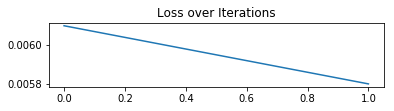

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
ax_loss = fig.add_subplot(311)
ax_loss.set_title('Loss over Iterations')
ax_loss.plot(history_of_precision[1])

# ax_roc = fig.add_subplot(313)
# ax_roc.set_title('ROC over Iterations')
# ax_roc.plot(np.array(histroy_of_roc)[:,1])

fig.canvas.draw()
plt.show()
# plt.savefig(fig_path + "bd_oh_5.png")

In [23]:
X_test, T_test = shuffleXY(X_val, T_val)
X_t = [construct_X(seqs_dicts[0], X_test, cutoff, n_gram_size, dimensions[0], 2000, 0),
       construct_X(seqs_dicts[1], X_test, cutoff, n_gram_size, dimensions[1], 2000, 0)]
T_t = np.array(T_test[0: 2000]).reshape(2000,cutoff,1)

In [55]:
x_t,y_t = randomSample(X_t, T_t)
output = model.predict(x_t)
print ("Min value : ", np.min(output[0])," Max value : ",np.max(output[0]))

print ("Binding site index [probability]")
for i in range(cutoff):
    if y_t[0][i] == 1:
        print (i, output[0][i])

print ("Output shape : ", output.shape)
print ("Positive predictions : ", np.sum((output.ravel() > 0) * 1.0)) 

Min value :  -0.332252  Max value :  0.250309
Binding site index [probability]
114 [ 0.19274254]
118 [ 0.18603942]
124 [ 0.17423834]
490 [-0.1914417]
494 [-0.1914417]
500 [-0.1914417]
Output shape :  (1, 706, 1)
Positive predictions :  55.0


In [21]:
print ((output.ravel() > 0) * 1.0) # bd_oh_rp_10

[ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1

In [72]:
print ((output.ravel() > 0) * 1.0) # bd_w2v_rp_20

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1

In [56]:
print ((output.ravel() > 0) * 1.0) # bd_oh_20

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0